In [49]:
import pandas as pd
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import numpy as np

In [50]:
df = pd.read_csv("ProcessedData/events.csv")
df = df[['Sport','NOC','Year','Medal','isHoster','Event']]
df

,Sport,NOC,Year,Medal,isHoster,Event
0,basketball,CHN,1992,No medal,0,basketball men's basketball
1,judo,CHN,2012,No medal,0,judo men's extra-lightweight
2,football,DEN,1920,No medal,0,football men's football
3,tug-of-war,DEN,1900,Gold,0,tug-of-war men's tug-of-war
4,athletics,NED,1932,No medal,0,athletics women's 100 metres
...,...,...,...,...,...,...
130761,athletics,USA,2024,No medal,0,women's 400m hurdles
130762,swimming,LAO,2024,No medal,0,men's 100m breaststroke
130763,judo,UKR,2024,No medal,0,women +78 kg
130764,athletics,GEQ,2024,No medal,0,women's 100m


In [51]:
# 数据预处理：拆分奖牌列为 Gold, Silver, Bronze, NoMedal
df['Gold'] = (df['Medal'] == 'Gold').astype(int)
df['Silver'] = (df['Medal'] == 'Silver').astype(int)
df['Bronze'] = (df['Medal'] == 'Bronze').astype(int)
df['NoMedal'] = (df['Medal'] == 'No medal').astype(int)

# 筛选主办年份数据
host_data = df[df['isHoster'] == 1]

# 统计每个 Sport 在每年中对应的 Event 数量
event_count = host_data.groupby(['Year', 'Sport'])['Event'].nunique().reset_index()
event_count.rename(columns={'Event': 'EventCount'}, inplace=True)

# 按 Year, Sport, NOC 分组，统计各类奖牌和总数
host_summary = host_data.groupby(['Year', 'Sport', 'NOC']).agg(
    Gold=('Gold', 'sum'),
    Silver=('Silver', 'sum'),
    Bronze=('Bronze', 'sum'),
    NoMedal=('NoMedal', 'sum')
).reset_index()

# 添加总奖牌数列
host_summary['TotalMedals'] = (
    host_summary['Gold'] +
    host_summary['Silver'] +
    host_summary['Bronze']
)

# 将 Event 数量合并到统计表中
host_summary = host_summary.merge(event_count, on=['Year', 'Sport'], how='left')

# 输出统计结果
print("主办年份的项目及奖牌分布统计（按年份）：")
# print(host_summary)

# 如果需要保存为 CSV 文件
host_summary.to_csv("ProcessedData/host_country_yearly_medal_summary_with_event_counts.csv", index=False)
host_summary

主办年份的项目及奖牌分布统计（按年份）：


,Year,Sport,NOC,Gold,Silver,Bronze,NoMedal,TotalMedals,EventCount
0,1896,athletics,GRE,1,3,5,9,9,10
1,1896,cycling,GRE,2,3,0,5,5,7
2,1896,fencing,GRE,4,2,2,3,8,4
3,1896,gymnastics,GRE,2,1,3,3,6,6
4,1896,shooting,GRE,7,7,6,9,20,10
...,...,...,...,...,...,...,...,...,...
570,2024,triathlon,FRA,1,0,1,2,2,2
571,2024,volleyball,FRA,1,0,0,1,1,2
572,2024,water polo,FRA,0,0,0,2,0,2
573,2024,weightlifting,FRA,0,0,0,4,0,4


In [52]:
from scipy.stats import chi2_contingency

# Construct contingency table: Sport vs TotalMedals
contingency_table = host_summary.pivot_table(
    values='TotalMedals', index='Sport', columns='NOC', aggfunc='sum', fill_value=0
)

# Remove rows and columns with zero values
contingency_table = contingency_table.loc[:, (contingency_table.sum(axis=0) > 0)]
contingency_table = contingency_table[(contingency_table.sum(axis=1) > 0)]

# Perform Chi-Square test after ensuring no zero values in the table
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output results
print("Chi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of Freedom: {dof}")
if p < 0.05:
    print("There is a significant association between the host country's chosen sports and total medals.")
else:
    print("There is no significant association between the host country's chosen sports and total medals.")


Chi-Square Test Results:
Chi-Square Statistic: 2558.6901303909285
p-value: 7.406758772945909e-171
Degrees of Freedom: 848
There is a significant association between the host country's chosen sports and total medals.


In [53]:
import statsmodels.api as sm

# Prepare data: Independent variable (isHoster) and dependent variable (TotalMedals)
df['Medals'] = df['Gold'] + df['Silver'] + df['Bronze']
X = sm.add_constant(df['isHoster'])  # Add a constant term
y = df['Medals']  # Dependent variable: Total medals

# Perform regression analysis
model = sm.OLS(y, X).fit()

# Output regression results
print(model.summary())

# Analyze results
if model.pvalues['isHoster'] < 0.05:
    print("The host country's status has a significant impact on the total number of medals.")
else:
    print("The host country's status does not have a significant impact on the total number of medals.")


                            OLS Regression Results                            
Dep. Variable:                 Medals   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1527.
Date:                Tue, 28 Jan 2025   Prob (F-statistic):               0.00
Time:                        00:12:13   Log-Likelihood:                -55322.
No. Observations:              130766   AIC:                         1.106e+05
Df Residuals:                  130764   BIC:                         1.107e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1572      0.001    150.720      0.0

Project distribution comparison between host years and non-host years:
                  Host Year  Non-Host Year
Sport                                     
3x3 basketball     0.000376       0.000239
aeronautics        0.000000       0.000008
alpinism           0.000000       0.000016
archery            0.021072       0.010299
art competitions   0.017686       0.006552
...                     ...            ...
tug-of-war         0.001317       0.000159
volleyball         0.004516       0.002519
water polo         0.005644       0.002981
weightlifting      0.027658       0.029525
wrestling          0.058137       0.066807

[70 rows x 2 columns]


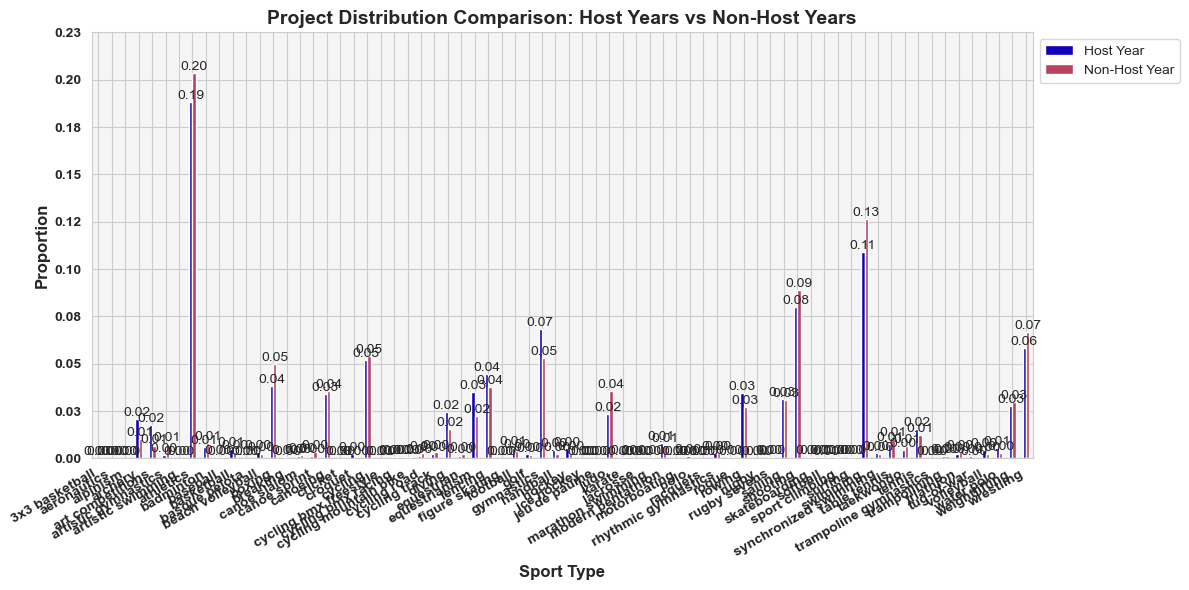

In [83]:
import matplotlib.pyplot as plt
import pandas as pd

# 计算主办年份和非主办年份的项目分布
host_sport_distribution = host_data['Sport'].value_counts(normalize=True)
non_host_sport_distribution = non_host_data['Sport'].value_counts(normalize=True)

# 合并分布数据
distribution_comparison = pd.DataFrame({
    'Host Year': host_sport_distribution,
    'Non-Host Year': non_host_sport_distribution
}).fillna(0)

# 输出项目分布对比
print("Project distribution comparison between host years and non-host years:")
print(distribution_comparison)

# 设置自定义颜色
colors = ['#1200BA', '#B74360']  # 蓝色和红色

# 创建柱状图
fig, ax = plt.subplots(figsize=(12, 6))
bars = distribution_comparison.plot(
    kind='bar',
    ax=ax,
    color=colors,
    edgecolor='white',
    linewidth=1
)

# 设置图表背景颜色
ax.set_facecolor('#F5F5F5')  # 图表区域背景为浅灰色
fig.patch.set_facecolor('#FFFFFF')  # 整个图表背景为白色

# 添加柱子顶部的数值标注
for i, container in enumerate(bars.containers):
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)

# 设置标题和轴标签
ax.set_title("Project Distribution Comparison: Host Years vs Non-Host Years", fontsize=14, fontweight='bold')
ax.set_xlabel("Sport Type", fontsize=12, fontweight='bold')
ax.set_ylabel("Proportion", fontsize=12, fontweight='bold')

# 设置刻度字体大小
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=30, ha='right', fontweight='bold')  # X 轴刻度
ax.set_yticks(ax.get_yticks())  # 明确设置 Y 轴刻度
ax.set_yticklabels([f'{tick:.2f}' for tick in ax.get_yticks()], fontsize=10, fontweight='bold')  # Y 轴刻度

# 设置图例
ax.legend(["Host Year", "Non-Host Year"], fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# 调整布局以避免文字重叠
plt.tight_layout()

# 显示图形
plt.show()


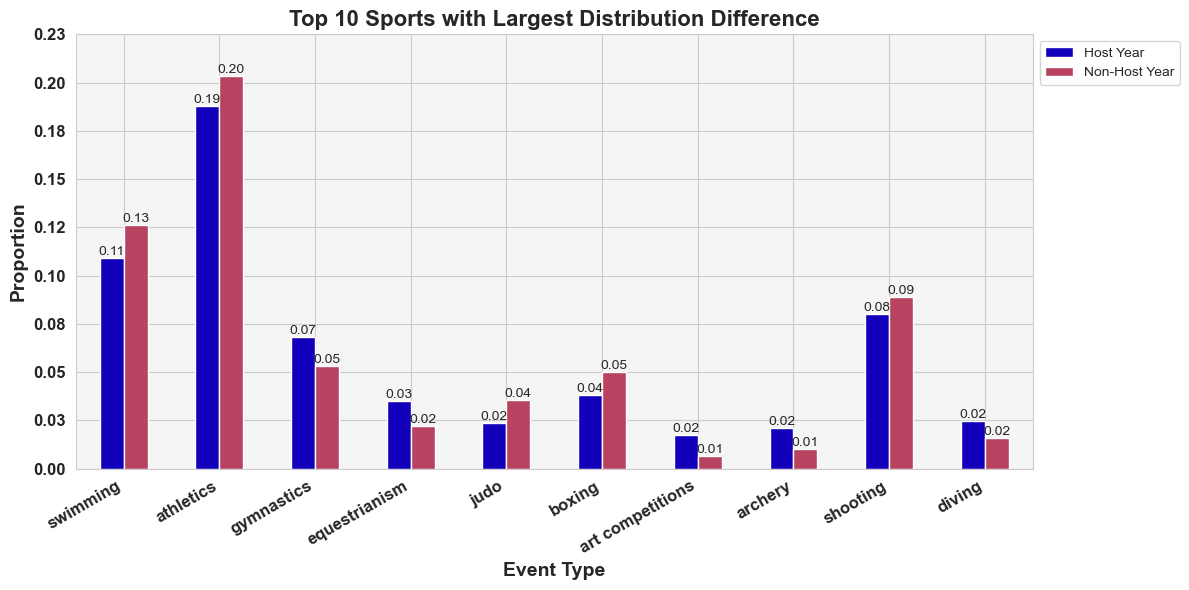

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置 Seaborn 风格
sns.set_style("whitegrid")

# 计算比例差异
distribution_comparison['Difference'] = abs(distribution_comparison['Host Year'] - distribution_comparison['Non-Host Year'])

# 筛选比例差异最大的前 N 个项目
top_n = 10
top_comparison = distribution_comparison.sort_values(by='Difference', ascending=False).head(top_n)

# 自定义颜色
colors = ['#1200BA', '#B74360']  # 蓝色和红色

# 创建柱状图
fig, ax = plt.subplots(figsize=(12, 6))
bars = top_comparison[['Host Year', 'Non-Host Year']].plot(
    kind='bar',
    ax=ax,
    color=colors,
    edgecolor='white',
    linewidth=1
)

# 设置图表背景颜色
ax.set_facecolor('#F5F5F5')  # 图表区域背景为浅灰色
fig.patch.set_facecolor('#FFFFFF')  # 整个图表背景为白色

# 添加柱子顶部的数值标注
for i, container in enumerate(bars.containers):
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)

# 设置标题和轴标签
ax.set_title(f"Top {top_n} Sports with Largest Distribution Difference", fontsize=16, fontweight='bold')
ax.set_xlabel("Event Type", fontsize=14, fontweight='bold')
ax.set_ylabel("Medals Proportion", fontsize=14, fontweight='bold')

# 设置刻度字体大小
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=30, ha='right', fontweight='bold')  # X 轴刻度
ax.set_yticks(ax.get_yticks())  # 明确设置 Y 轴刻度
ax.set_yticklabels([f'{tick:.2f}' for tick in ax.get_yticks()], fontsize=12, fontweight='bold')  # Y 轴刻度

# 设置图例
ax.legend(["Host Year", "Non-Host Year"], fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# 调整布局以避免文字重叠
plt.tight_layout()

# 显示图形
plt.show()
